![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <Center>DengIA</Center>

## IMPORTS

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from random import randint
from IPython.display import clear_output

from sklearn.model_selection import  train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

## DATASET

In [92]:
# Lee los archivos CSV
df1 = pd.read_csv('https://raw.githubusercontent.com/Nestorbd/DengIA-Competition/master/datasets/dengue_features_train.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/Nestorbd/DengIA-Competition/master/datasets/dengue_labels_train.csv')

# Combina los dos DataFrames usando merge
df_combined = pd.merge(df1, df2, how='outer', on=['city', 'year', 'weekofyear'])

# Guarda el DataFrame combinado en un nuevo archivo CSV
df_combined.to_csv('dengue_train.csv', index=False)
df_combined.shape

(1456, 25)

In [93]:
df_combined['city'].replace(['iq', 'sj'],[0, 1], inplace=True)

df_combined['week_start_date'] = pd.to_datetime(df_combined['week_start_date'])
df_combined['week_start_date'] = (df_combined['week_start_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

## OVERVIEW

In [94]:
df_combined.describe()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,0.642857,2001.031593,26.503434,11512.667582,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,0.479322,5.408314,15.019437,1970.417074,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,0.000000,1990.000000,1.000000,7424.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,0.000000,1997.000000,13.750000,9979.250000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,1.000000,2002.000000,26.500000,11835.000000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,1.000000,2005.000000,39.250000,13113.000000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,1.000000,2010.000000,53.000000,14785.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


In [95]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   int64  
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   int64  
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

## ANÁLISIS

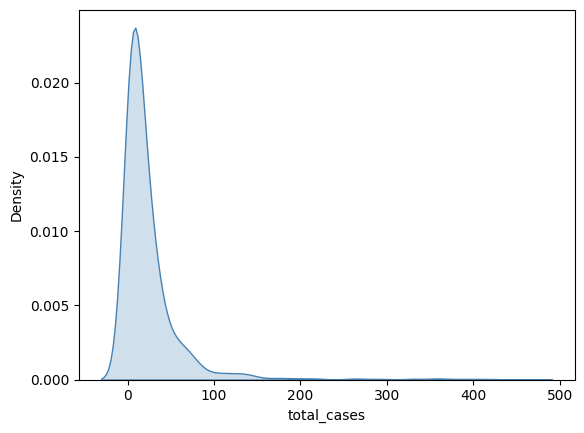

In [96]:
sns.kdeplot(data = df_combined, x = 'total_cases', fill = True, color = 'steelblue');

## PROCESAMIENTO DE DATOS

### QUITAR NULOS

In [97]:
df_combined = df_combined.dropna()

### OUTLIERS

In [98]:
k=1.8 
for i,column in enumerate(df_combined,1):
  print(column)
  Q1 = np.quantile(df_combined[column],0.25)
  Q3 = np.quantile(df_combined[column],0.75)
  IQR = Q3 - Q1 
  xL=Q1 - k * IQR
  xU=Q3 + k * IQR
  print(f" Banda= [ {xL},{xU}]")
  outlaiers = 0
  for x in  range(len(df_combined)):
      if x in df_combined.index:
          if df_combined[column][x] < xL  or df_combined[column][x]>xU:
               outlaiers +=1
  print(f"Hay {outlaiers} outlaiers")

city
 Banda= [ -1.8,2.8]
Hay 0 outlaiers
year
 Banda= [ 1983.6,2020.4]
Hay 0 outlaiers
weekofyear
 Banda= [ -31.0,84.0]
Hay 0 outlaiers
week_start_date
 Banda= [ 4940.099999999999,18477.9]
Hay 0 outlaiers
ndvi_ne
 Banda= [ -0.32559139,0.61489494]
Hay 1 outlaiers
ndvi_nw
 Banda= [ -0.25284074000000006,0.52514254]
Hay 2 outlaiers
ndvi_se
 Banda= [ -0.01888998,0.42704713]
Hay 2 outlaiers
ndvi_sw
 Banda= [ -0.05205999999999994,0.45140999999999987]
Hay 3 outlaiers
precipitation_amt_mm
 Banda= [ -94.037,178.352]
Hay 10 outlaiers
reanalysis_air_temp_k
 Banda= [ 293.7581428569998,303.6711428570002]
Hay 0 outlaiers
reanalysis_avg_temp_k
 Banda= [ 294.8114285728,303.6992857127]
Hay 0 outlaiers
reanalysis_dew_point_temp_k
 Banda= [ 290.1021428575999,300.6164285709001]
Hay 2 outlaiers
reanalysis_max_air_temp_k
 Banda= [ 292.2800000000001,314.81999999999994]
Hay 0 outlaiers
reanalysis_min_air_temp_k
 Banda= [ 285.8600000000001,305.6399999999999]
Hay 0 outlaiers
reanalysis_precip_amt_kg_per_m2
 Band

In [99]:
# Calcular el rango intercuartílico (IQR) para cada columna
Q1 = df_combined.quantile(0.25)
Q3 = df_combined.quantile(0.75)
IQR = Q3 - Q1
xL=Q1 - k * IQR
xU=Q3 + k * IQR

# Definir un filtro para eliminar outliers
filtro_outliers = ~((df_combined < xL) | (df_combined > xU)).any(axis=1)

# Aplicar el filtro para mantener solo los datos sin outliers
df_sin_outliers = df_combined[filtro_outliers].reset_index(drop=True)

# Visualizar la diferencia de filas
outlaiers = df_combined.shape[0]- df_sin_outliers.shape[0]

# Verificar la forma del DataFrame después de eliminar outliers
print(f'Forma del DataFrame antes de eliminar outliers: {df_combined.shape}')
print(f'Forma del DataFrame después de eliminar outliers: {df_sin_outliers.shape}')
print(f'Se han eliminado {outlaiers} outliers')

Forma del DataFrame antes de eliminar outliers: (1199, 25)
Forma del DataFrame después de eliminar outliers: (979, 25)
Se han eliminado 220 outliers


### NORMALIZACIÓN

In [100]:
column_names = df_sin_outliers.columns.values
index_to_remove = np.where(column_names == 'total_cases')[0]
column_names = np.delete(column_names, index_to_remove)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_sin_outliers.drop('total_cases', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

df_complete = scaled_df.copy()
df_complete["total_cases"] = df_sin_outliers['total_cases']

### SELECCIÓN DE CARACTERÍSTICAS

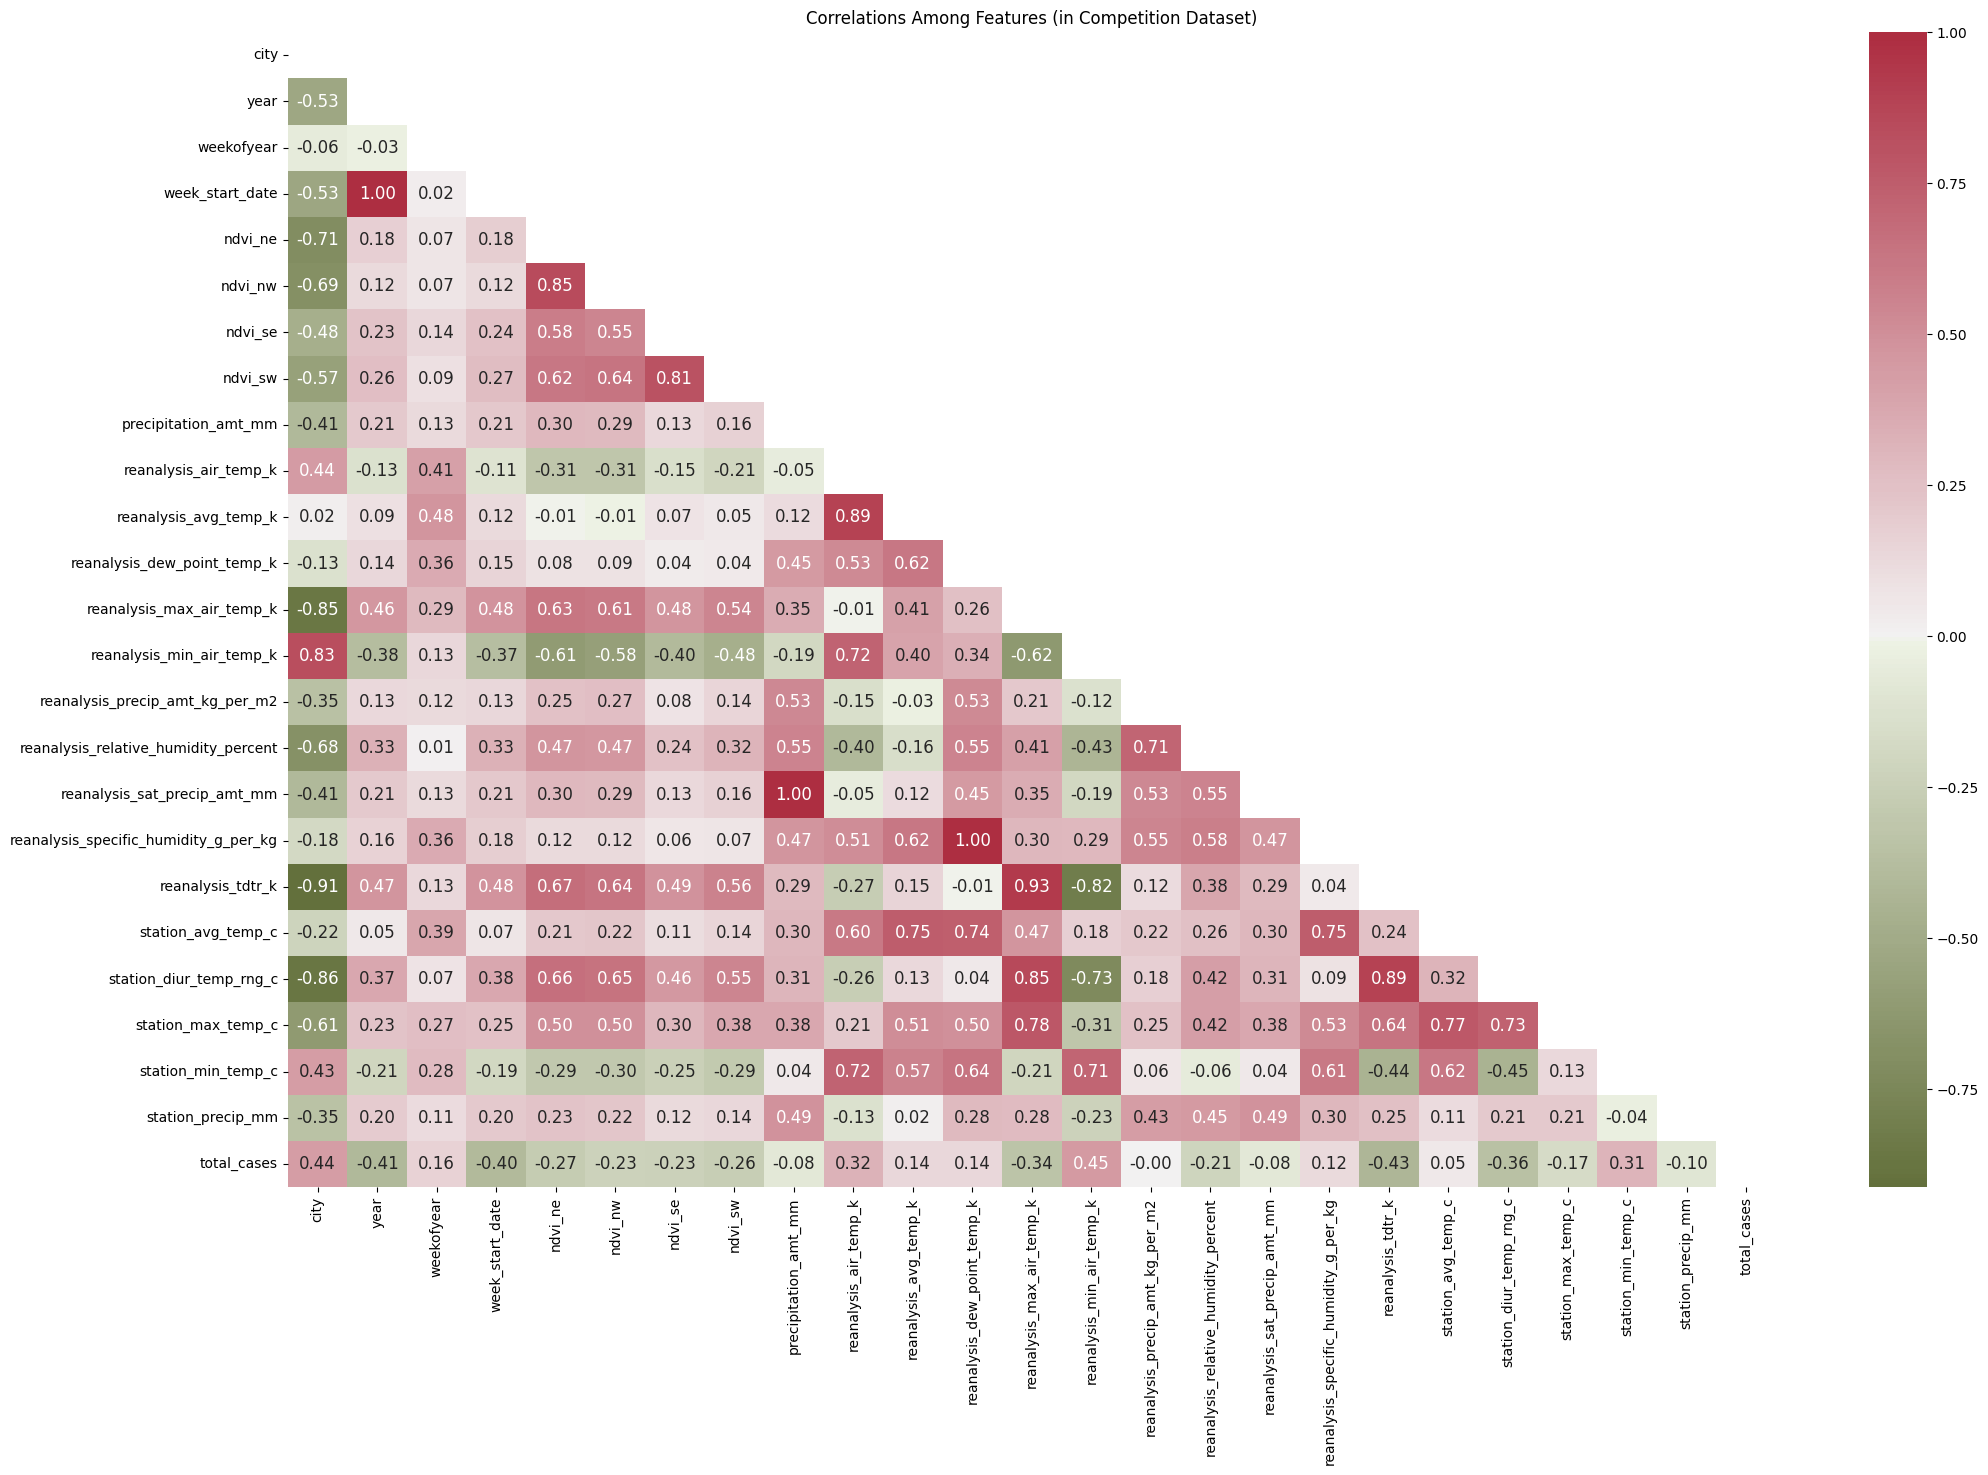

In [101]:
# Calcular la matriz de correlación
corr_mat_data = df_complete.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (24, 15))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)');

In [102]:
X = scaled_df
y = df_sin_outliers['total_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión LASSO
lasso_model = Lasso(alpha=1.0)

# Entrenar el modelo
lasso_model.fit(X_train, y_train)

# Obtener los coeficientes no nulos (características seleccionadas)
selected_features = X.columns[lasso_model.coef_ != 0]

# Mostrar las características seleccionadas
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['year', 'weekofyear', 'reanalysis_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k'],
      dtype='object')


### DIVIDIR LOS DATOS

In [103]:
X = scaled_df[selected_features]
y = df_sin_outliers['total_cases']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## SELECCIONAR UN MODELO

In [104]:
def best_params(model, params, min_splits=2, max_splits=100, CV_technique = "all"):
    best_split = 100
    best_params = {}
    best_score = float('inf')
    technique = "anyone"

    if (CV_technique == "anyone" or CV_technique == "all"):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        if(mae < best_score):
            best_score = mae
            technique = "anyone"
            best_params = {}
    if(CV_technique != "anyone"):
        while (max_splits - min_splits) >= 10:
            split = randint(min_splits, max_splits)
            min = split - 5
            max = split + 5

            if(min < min_splits):
                min = min_splits
            if(max > max_splits):
                max = max_splits

            for s in range(min,max):
                clear_output()
                print("min:",min_splits, "max:",max_splits, "actual:", split)
                print("search:", min, "-",max, "actual:",s)
                if(CV_technique == "gridSearchCV" or CV_technique == "all"):
                    # Inicializar GridSearchCV
                    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=s, n_jobs=-1, scoring='neg_mean_absolute_error')

                    # Ajustar el modelo utilizando GridSearchCV
                    grid_search.fit(X_train, y_train)

                    if(- grid_search.best_score_ < best_score):

                        # Obtener los mejores hiperparámetros
                        best_params = grid_search.best_params_
                        best_score =  - grid_search.best_score_
                        technique = "gridSearchCV"
                        best_split = s
                    print("gridSearchCV Finish")

                if(CV_technique == "randomizeSearchCV" or CV_technique == "all"):
                    # Inicializar GridSearchCV
                    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=10, cv=s, n_jobs=-1, scoring='neg_mean_absolute_error')
                                # Ajustar el modelo utilizando GridSearchCV
                    random_search.fit(X_train, y_train)

                    if(- random_search.best_score_ < best_score):

                        # Obtener los mejores hiperparámetros
                        best_params = random_search.best_params_
                        best_score =  - random_search.best_score_
                        technique = "randomizeSearchCV"
                        best_split = s
                    print("randomizeSearchCV Finish")
                
                s+=1

            if(best_split>split):
                min_splits = best_split
            elif(best_split<split):
                max_splits = best_split
            elif(best_split==split):
                prob = randint(0, 100)
                if(prob > 50):
                    max_splits = best_split
                else:
                    min_splits = best_split


            
    return  best_score, best_params, technique, best_split



### RANDOM FOREST

In [105]:
# Definir los hiperparámetros a ajustar
params_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Inicializar el modelo Random Forest
rf = RandomForestRegressor()

In [106]:
best_mae_rf, best_params_rf, best_technique_rf, best_splits_rf = best_params(model=rf, params=params_rf, CV_technique="all", max_splits=15)
print("Best MAE:",best_mae_rf,", Best params:", best_params_rf,", Best technique:", best_technique_rf,", Best splits:", best_splits_rf)


min: 2 max: 15 actual: 4
search: 2 - 9 actual: 8
gridSearchCV Finish
randomizeSearchCV Finish
Best MAE: 6.7078257870821165 , Best params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None} , Best technique: randomizeSearchCV , Best splits: 8


#### GridSearchCV

In [107]:
# Inicializar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=best_splits_rf, n_jobs=-1, scoring='neg_mean_absolute_error')

# Ajustar el modelo utilizando GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_grid_search_rf = grid_search_rf.best_params_
best_score_grid_search_rf =  - grid_search_rf.best_score_
print("Mejores hiperparámetros:", best_params_grid_search_rf)
print("MAE: ", best_score_grid_search_rf)

Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
MAE:  6.718032091853295


In [108]:
# Realizar la validación cruzada para obtener las predicciones
y_pred_val_gscv_rf = cross_val_predict(grid_search_rf, X_val, y_val, cv=5)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_gscv_rf = mean_absolute_error(y_val, y_pred_val_gscv_rf)

print(f"Mean Absolute Error: {mae_gscv_rf}")


Mean Absolute Error: 7.173249282536966


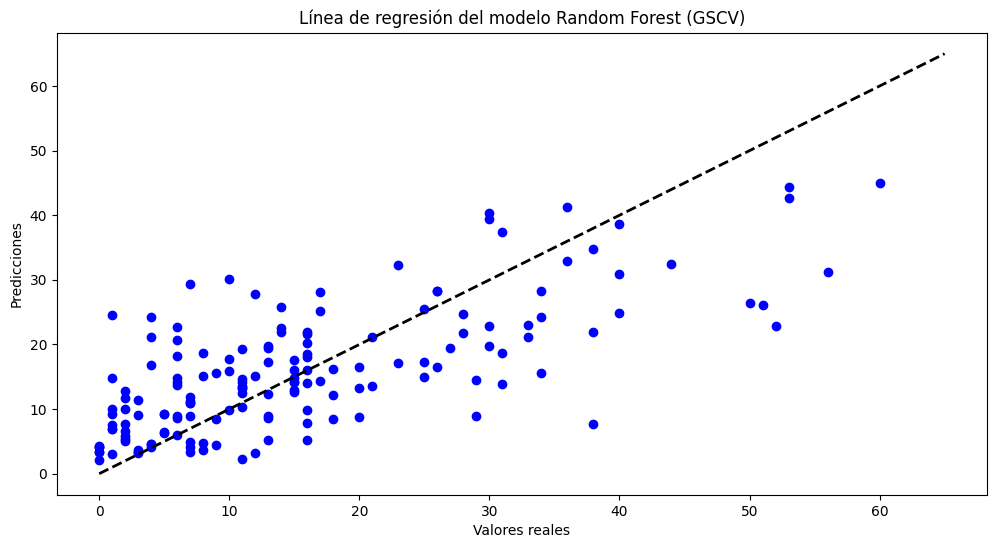

In [109]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_val,y_pred_val_gscv_rf, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo Random Forest (GSCV)')
plt.show()

#### RandomizedSearchCV

In [110]:
# Inicializar GridSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=params_rf, n_iter=10, cv=best_splits_rf, n_jobs=-1, scoring='neg_mean_absolute_error')

# Ajustar el modelo utilizando GridSearchCV
random_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_random_search_rf = random_search_rf.best_params_
best_score_random_search_rf =  - random_search_rf.best_score_
print("Mejores hiperparámetros:", best_params_random_search_rf)
print("MAE: ", best_score_random_search_rf)

Mejores hiperparámetros: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None}
MAE:  6.75523923509683


In [111]:
# Realizar la validación cruzada para obtener las predicciones
y_pred_val_rscv_rf = cross_val_predict(random_search_rf, X_val, y_val, cv=5)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_rscv_rf = mean_absolute_error(y_val, y_pred_val_rscv_rf)

print(f"Mean Absolute Error: {mae_rscv_rf}")

Mean Absolute Error: 7.251558354696757


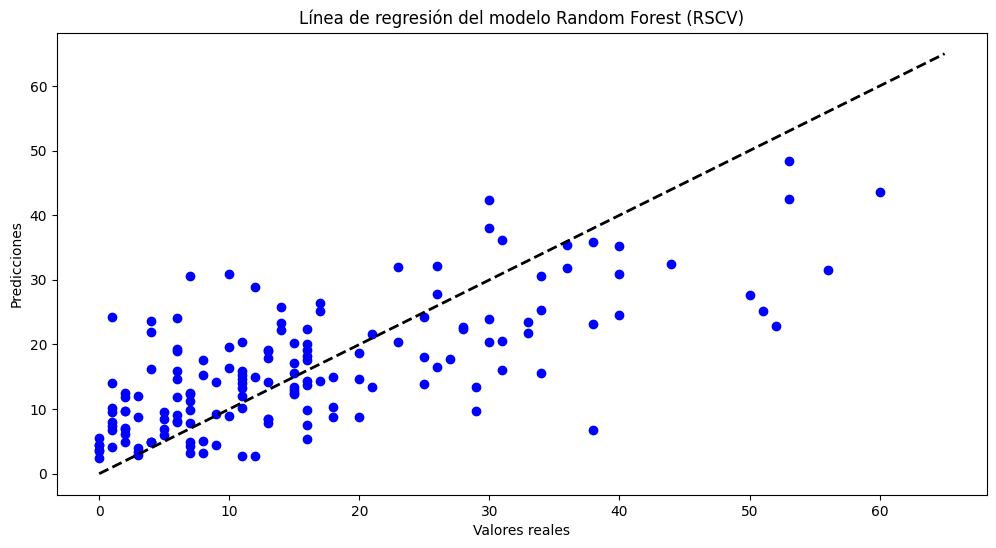

In [112]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_val,y_pred_val_rscv_rf, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo Random Forest (RSCV)')
plt.show()

### Gradient Boosting

In [113]:
# Definir los hiperparámetros a ajustar
params_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Inicializar el modelo Gradient Boosting Regressor
gb = GradientBoostingRegressor()

In [114]:
best_mae_gb, best_params_gb, best_technique_gb, best_splits_gb = best_params(model=gb, params=params_gb, CV_technique="all", max_splits=15)
print("Best MAE:",best_mae_gb,", Best params:", best_params_gb,", Best technique:", best_technique_gb,", Best splits:", best_splits_gb)

min: 2 max: 15 actual: 10
search: 5 - 15 actual: 14
gridSearchCV Finish
randomizeSearchCV Finish
Best MAE: 6.238269684497782 , Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} , Best technique: gridSearchCV , Best splits: 10


#### GridSearchCV

In [115]:
# Inicializar RandomizedSearchCV con MAE como métrica
grid_search_gb = GridSearchCV(estimator=gb, param_grid=params_gb, cv=best_splits_gb, n_jobs=-1, scoring='neg_mean_absolute_error')

# Ajustar el modelo utilizando RandomizedSearchCV
grid_search_gb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_grid_search_gb = grid_search_gb.best_params_
best_score_grid_search_gb =  - grid_search_gb.best_score_
print("Mejores hiperparámetros:", best_params_grid_search_gb)
print("MAE: ", best_score_grid_search_gb)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
MAE:  6.253153663208154


In [116]:
# Realizar la validación cruzada para obtener las predicciones
y_pred_val_gscv_gb = cross_val_predict(grid_search_gb, X_val, y_val, cv=5)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_gscv_gb = mean_absolute_error(y_val, y_pred_val_gscv_gb)

print(f"Mean Absolute Error: {mae_gscv_gb}")

Mean Absolute Error: 7.378971778304862


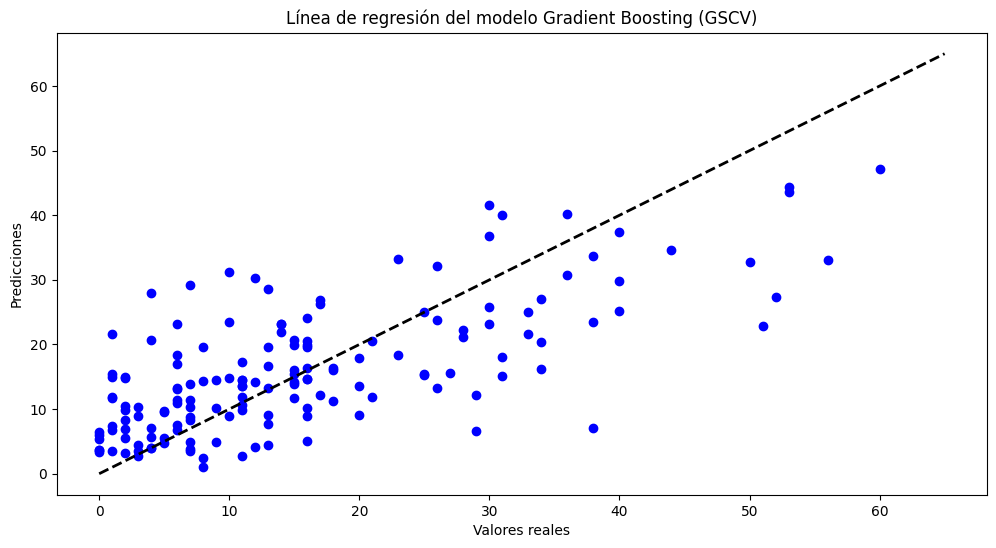

In [117]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_val,y_pred_val_gscv_gb, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo Gradient Boosting (GSCV)')
plt.show()

#### RandomizedSearchCV

In [118]:
# Inicializar RandomizedSearchCV con MAE como métrica
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=params_gb, n_iter=10, cv=best_splits_gb, n_jobs=-1, scoring='neg_mean_absolute_error')

# Ajustar el modelo utilizando RandomizedSearchCV
random_search_gb.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_random_search_gb = random_search_gb.best_params_
best_score_random_search_gb =  - random_search_gb.best_score_
print("Mejores hiperparámetros:", best_params_random_search_gb)
print("MAE: ", best_score_random_search_gb)

Mejores hiperparámetros: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
MAE:  6.34224300688675


In [119]:
# Realizar la validación cruzada para obtener las predicciones
y_pred_val_rscv_gb = cross_val_predict(random_search_gb, X_val, y_val, cv=5)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_rscv_gb = mean_absolute_error(y_val, y_pred_val_rscv_gb)

print(f"Mean Absolute Error: {mae_rscv_gb}")

Mean Absolute Error: 7.54734731124086


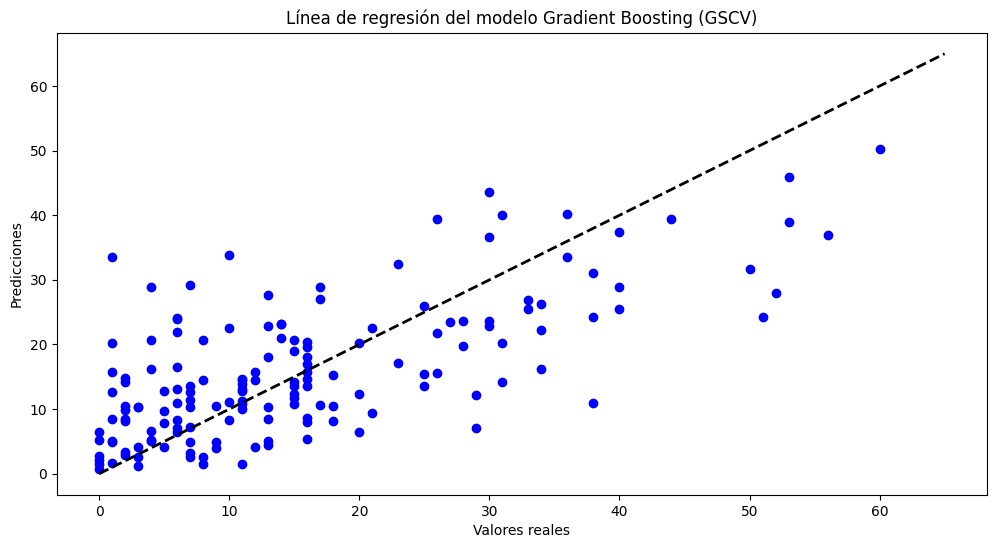

In [120]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_val,y_pred_val_rscv_gb, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo Gradient Boosting (GSCV)')
plt.show()

### KNN

In [121]:
# Define el espacio de búsqueda de parámetros
params_knn = {'n_neighbors': np.arange(1, 51), 'weights': ['uniform', 'distance']}

# Crea el modelo KNN
knn = KNeighborsRegressor()

In [122]:
best_mae_knn, best_params_knn, best_technique_knn, best_splits_knn = best_params(model=knn, params=params_knn, CV_technique="all")
print("Best MAE:",best_mae_knn,", Best params:", best_params_knn,", Best technique:", best_technique_knn,", Best splits:", best_splits_knn)

min: 49 max: 100 actual: 52
search: 49 - 57 actual: 56
gridSearchCV Finish
randomizeSearchCV Finish
Best MAE: 7.30562043373942 , Best params: {'n_neighbors': 5, 'weights': 'distance'} , Best technique: gridSearchCV , Best splits: 49


#### GridSearchCV

In [123]:
# Inicializar GridSearchCV con MAE como métrica
grid_search_knn = GridSearchCV(estimator=knn, param_grid=params_knn, cv=best_splits_knn, n_jobs=-1, scoring='neg_mean_absolute_error')

# Ajustar el modelo utilizando GridSearchCV
grid_search_knn.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_grid_search_knn = grid_search_knn.best_params_
best_score_grid_search_knn =  - grid_search_knn.best_score_
print("Mejores hiperparámetros:", best_params_grid_search_knn)
print("MAE: ", best_score_grid_search_knn)

Mejores hiperparámetros: {'n_neighbors': 5, 'weights': 'distance'}
MAE:  7.30562043373942


In [124]:
# Realizar la validación cruzada para obtener las predicciones
y_pred_val_gscv_knn = cross_val_predict(grid_search_knn, X_val, y_val, cv=5)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_gscv_knn = mean_absolute_error(y_val, y_pred_val_gscv_knn)

print(f"Mean Absolute Error: {mae_gscv_knn}")

Mean Absolute Error: 8.422822740020925


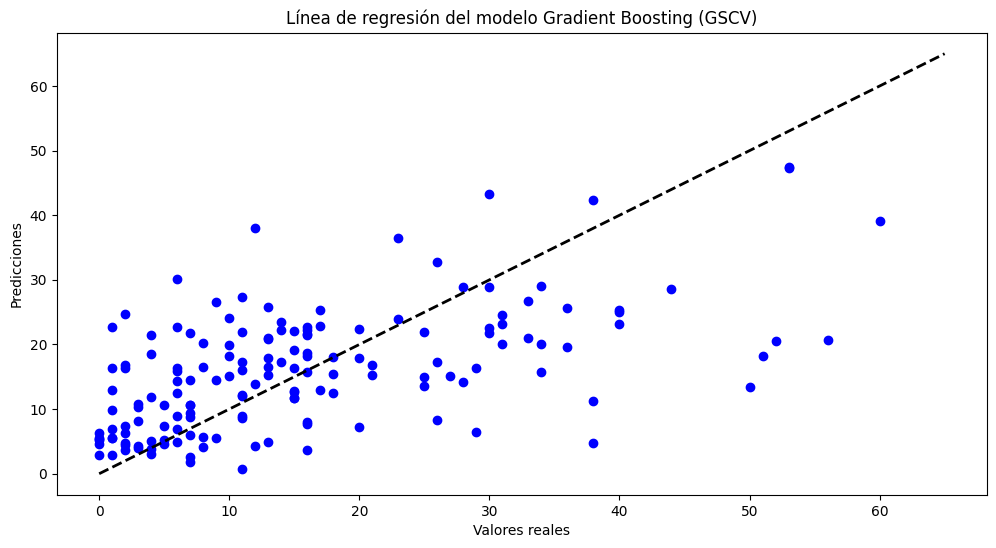

In [125]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_val,y_pred_val_gscv_knn, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo Gradient Boosting (GSCV)')
plt.show()

#### RandomizedSearchCV

In [126]:
# Inicializar RandomizedSearchCV con MAE como métrica
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=params_knn, n_iter=10, cv=best_splits_knn, n_jobs=-1, scoring='neg_mean_absolute_error')

# Ajustar el modelo utilizando RandomizedSearchCV
random_search_knn.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_random_search_knn = random_search_knn.best_params_
best_score_random_search_knn =  - random_search_knn.best_score_
print("Mejores hiperparámetros:", best_params_random_search_knn)
print("MAE: ", best_score_random_search_knn)

Mejores hiperparámetros: {'weights': 'uniform', 'n_neighbors': 5}
MAE:  7.427943485086342


In [127]:
# Realizar la validación cruzada para obtener las predicciones
y_pred_val_rscv_knn = cross_val_predict(random_search_knn, X_val, y_val, cv=5)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_rscv_knn = mean_absolute_error(y_val, y_pred_val_rscv_knn)

print(f"Mean Absolute Error: {mae_rscv_knn}")

Mean Absolute Error: 8.256587341607634


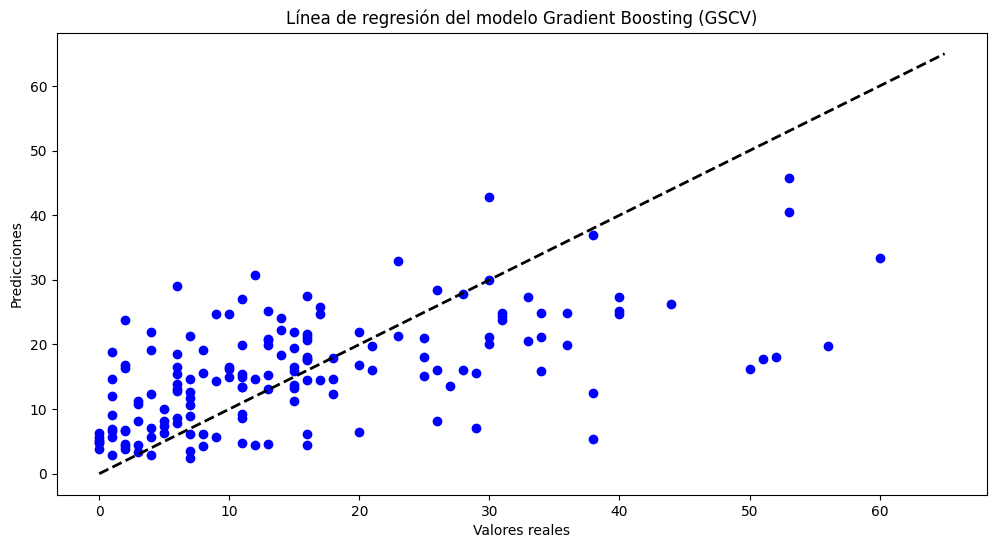

In [128]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
# Trazar la línea de regresión
plt.scatter(y_val,y_pred_val_rscv_knn, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Línea de regresión del modelo Gradient Boosting (GSCV)')
plt.show()

### EXPORTAR MODELO

#### Random Forest

In [129]:
joblib.dump(grid_search_rf,'trained_models/dengIA_rf_modelo_entrenado.pkl')

['trained_models/dengIA_rf_modelo_entrenado.pkl']

#### Gradient Boosting

In [130]:
joblib.dump(grid_search_gb,'trained_models/dengIA_gb_modelo_entrenado.pkl')

['trained_models/dengIA_gb_modelo_entrenado.pkl']

#### KNN

In [131]:
joblib.dump(random_search_knn,'trained_models/dengIA_knn_modelo_entrenado.pkl')

['trained_models/dengIA_knn_modelo_entrenado.pkl']

### IMPORTAR MODELO

#### Random Forest

In [132]:
random_forest = joblib.load('trained_models/dengIA_rf_modelo_entrenado.pkl')

In [133]:
# Hacer predicciones con el modelo cargado
predictions_rf = random_forest.predict(X_test)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_rf = mean_absolute_error(y_test, predictions_rf)

print(f"Random Forest MAE: {mae_rf}")

Random Forest MAE: 6.771071428571428


#### Gradient Boosting

In [134]:
gradient_boosting = joblib.load('trained_models/dengIA_gb_modelo_entrenado.pkl')

In [135]:
# Hacer predicciones con el modelo cargado
predictions_gb = gradient_boosting.predict(X_test)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_gb = mean_absolute_error(y_test, predictions_gb)

print(f"Gradient Boosting MAE: {mae_gb}")

Gradient Boosting MAE: 6.646383523748631


#### KNN

In [136]:
knn_model = joblib.load('trained_models/dengIA_knn_modelo_entrenado.pkl')

In [137]:
# Hacer predicciones con el modelo cargado
predictions_knn = knn_model.predict(X_test)

# Calcular el Mean Absolute Error (MAE) entre las predicciones y los valores reales
mae_knn = mean_absolute_error(y_test, predictions_knn)

print(f"KNN MAE: {mae_knn}")

KNN MAE: 7.98265306122449


## PREDICCION CON LOS DATOS DE LA COMPETICIÓN

In [139]:
# Cargar el archivo CSV con los datos a predecir
data_to_predict = pd.read_csv('https://raw.githubusercontent.com/Nestorbd/DengIA-Competition/master/datasets/dengue_features_test.csv')

In [140]:
data_to_predict['city'].replace(['iq', 'sj'],[0, 1], inplace=True)

data_to_predict['week_start_date'] = pd.to_datetime(data_to_predict['week_start_date'])
data_to_predict['week_start_date'] = (data_to_predict['week_start_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

for column in data_to_predict.columns:
    # Verifica si la columna tiene valores nulos
    if data_to_predict[column].isnull().any():
        # Calcula la mediana de cada columna con datos nulos
        media = data_to_predict[column].mean()
        data_to_predict[column].fillna(media, inplace=True)


In [141]:
column_names_test = data_to_predict.columns.values

scaler_test = StandardScaler()
scaled_data_test = scaler_test.fit_transform(data_to_predict)
scaled_df_test = pd.DataFrame(scaled_data_test, columns=column_names_test)

In [142]:
scaled_df_test = scaled_df_test[selected_features]

### Random Forest

In [143]:
# Realizar las predicciones con el modelo importado
predictions_rf = random_forest.predict(scaled_df_test)

results_rf = data_to_predict.copy()

results_rf["total_cases"] = predictions_rf.astype('int')

results_rf = results_rf[['city', 'year', 'weekofyear', 'total_cases']]

results_rf['city'].replace([0, 1],['iq', 'sj'], inplace=True)

# Guardar las columnas seleccionadas en un archivo CSV
results_rf.to_csv('results/dengIA_rf_results.csv', index=False)



### Gradient Boosting

In [144]:
# Realizar las predicciones con el modelo importado
predictions_gb = gradient_boosting.predict(scaled_df_test)

results_gb = data_to_predict.copy()

results_gb["total_cases"] = predictions_gb.astype('int')

results_gb = results_gb[['city', 'year', 'weekofyear', 'total_cases']]

results_gb['city'].replace([0, 1],['iq', 'sj'], inplace=True)

# Guardar las columnas seleccionadas en un archivo CSV
results_gb.to_csv('results/dengIA_gb_results.csv', index=False)



### KNN

In [145]:
# Realizar las predicciones con el modelo importado
predictions_knn = knn_model.predict(scaled_df_test)

results_knn = data_to_predict.copy()

results_knn["total_cases"] = predictions_knn.astype('int')

results_knn = results_knn[['city', 'year', 'weekofyear', 'total_cases']]

results_knn['city'].replace([0, 1],['iq', 'sj'], inplace=True)

# Guardar las columnas seleccionadas en un archivo CSV
results_knn.to_csv('results/dengIA_knn_results.csv', index=False)

